# Extracting Shapley DNN Semantics - EXPERIMENT

<img src = 'https://media.nationalgeographic.org/assets/photos/000/273/27302_c0-41-990-701_r1050x700.jpg?d4ccf3044d9da0d0118103be3a76bd1319370847' >

## Importing all necessary libraries


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import enum
import os
import platform
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import plotly.io as pio

### Setting random seed

In [39]:
tf.random.set_seed(42)

## Define the possible nodes

In [40]:
class Mode(enum.Enum):
    TRAIN = "TRAIN"
    TEST = "TEST"

## Define the current run-mode

In [41]:
PC_NAME = platform.node().replace(" ", "_").replace(".", "_")
MODEL_DIR = f"../../output/titanic/models/experiment/{PC_NAME}"
PLOT_DIR = f"{MODEL_DIR}/plots"
MODE = Mode.TEST
if MODE == Mode.TEST and not os.path.exists(MODEL_DIR):
    print(f"Error: model not created (path \"{MODEL_DIR}\" does not exist), mode will be Mode.TRAIN")
    MODE = Mode.TRAIN

Error: model not created (path "../../output/titanic/models/experiment/MacBook-Pro-van-Bo_local" does not exist), mode will be Mode.TRAIN


In [42]:
def show_and_save_current_matplotlib_plt(plotname: str):
    if not os.path.exists(PLOT_DIR):
        os.makedirs(PLOT_DIR)
    file_n = f"{PLOT_DIR}/{plotname}"
    plt.savefig(file_n)
    plt.show()

def show_and_save_current_plotly_plt(plotname: str, fig, show=True):
    if not os.path.exists(PLOT_DIR):
        os.makedirs(PLOT_DIR)
    file_n = f"{PLOT_DIR}/{plotname}"
    if show:
        fig.show()
    pio.write_image(fig, file_n)

## Training the network

### Dropping PassengerId

In [43]:
titanic_data = pd.read_csv('../../input/titanic/experiment/titanic-experiment-preprocessed.csv')
columns_to_drop = ['PassengerId']
titanic_data.drop(columns_to_drop, axis=1, inplace=True)

### Splitting train and test sets

In [44]:
X_train = titanic_data.drop("Survived", axis=1)
Y_train = titanic_data["Survived"]

# Split data into 85% training and 15% testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.15, shuffle=True)

# Convert Y_train and Y_test to categorical
Y_train = to_categorical(np.array(Y_train), num_classes=2)
Y_test = to_categorical(np.array(Y_test), num_classes=2)

In [45]:
n_inputs = len(X_train.columns)

## Defining model
Here, I have used different number of neurons for each layer and different value for dropout. You can play with these hyperparameter for better outut.

In [46]:
def make_model():
    model = Sequential()
    model.add(Dense(units=16, input_shape=(n_inputs,), activation='relu'))
    model.add(Dense(units=32, activation='relu', kernel_initializer='he_normal', use_bias=False))
    model.add(Dense(units=2, activation='softmax'))
    return model


model = make_model()

## Model summary

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                432       
                                                                 
 dense_4 (Dense)             (None, 32)                512       
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________


## Compiling and fitting model

In [48]:
if MODE == Mode.TRAIN:
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
    model.fit(X_train, Y_train, batch_size=16, verbose=2, epochs=1000)
    model.save(MODEL_DIR)
else:
    model.load_weights(MODEL_DIR)

Epoch 1/1000
48/48 - 1s - loss: 0.6300 - acc: 0.6486 - 596ms/epoch - 12ms/step
Epoch 2/1000
48/48 - 0s - loss: 0.5033 - acc: 0.7741 - 45ms/epoch - 944us/step
Epoch 3/1000
48/48 - 0s - loss: 0.4788 - acc: 0.7715 - 42ms/epoch - 874us/step
Epoch 4/1000
48/48 - 0s - loss: 0.4633 - acc: 0.8032 - 42ms/epoch - 877us/step
Epoch 5/1000
48/48 - 0s - loss: 0.4514 - acc: 0.8058 - 47ms/epoch - 984us/step
Epoch 6/1000
48/48 - 0s - loss: 0.4436 - acc: 0.8151 - 47ms/epoch - 988us/step
Epoch 7/1000
48/48 - 0s - loss: 0.4363 - acc: 0.8071 - 45ms/epoch - 943us/step
Epoch 8/1000
48/48 - 0s - loss: 0.4292 - acc: 0.8098 - 45ms/epoch - 940us/step
Epoch 9/1000
48/48 - 0s - loss: 0.4259 - acc: 0.8111 - 38ms/epoch - 792us/step
Epoch 10/1000
48/48 - 0s - loss: 0.4251 - acc: 0.8124 - 39ms/epoch - 808us/step
Epoch 11/1000
48/48 - 0s - loss: 0.4168 - acc: 0.8151 - 38ms/epoch - 782us/step
Epoch 12/1000
48/48 - 0s - loss: 0.4124 - acc: 0.8164 - 40ms/epoch - 825us/step
Epoch 13/1000
48/48 - 0s - loss: 0.4115 - acc: 0.

INFO:tensorflow:Assets written to: ../../output/titanic/models/experiment/MacBook-Pro-van-Bo_local/assets


INFO:tensorflow:Assets written to: ../../output/titanic/models/experiment/MacBook-Pro-van-Bo_local/assets


### Prediction for test data

In [49]:
from sklearn import metrics

Y_pred_rand = [0 if x[0] > x[1] else 1 for x in model.predict(X_test)]
Y_test_flat = [0 if x[0] > x[1] else 1 for x in Y_test]
print("*" * 10, ' TEST RESULTS ', "*" * 10)
print('Precision : ', np.round(metrics.precision_score(Y_test_flat, Y_pred_rand) * 100, 2))
print('Accuracy : ', np.round(metrics.accuracy_score(Y_test_flat, Y_pred_rand) * 100, 2))
print('Recall : ', np.round(metrics.recall_score(Y_test_flat, Y_pred_rand) * 100, 2))
print('F1 score : ', np.round(metrics.f1_score(Y_test_flat, Y_pred_rand) * 100, 2))
print('AUC : ', np.round(metrics.roc_auc_score(Y_test_flat, Y_pred_rand) * 100, 2))
print("*" * 10, ' TEST RESULTS ', "*" * 10)

5/5 [==============================] - 0s 2ms/step
**********  TEST RESULTS  **********
Precision :  81.48
Accuracy :  84.33
Recall :  80.0
F1 score :  80.73
AUC :  83.67
**********  TEST RESULTS  **********


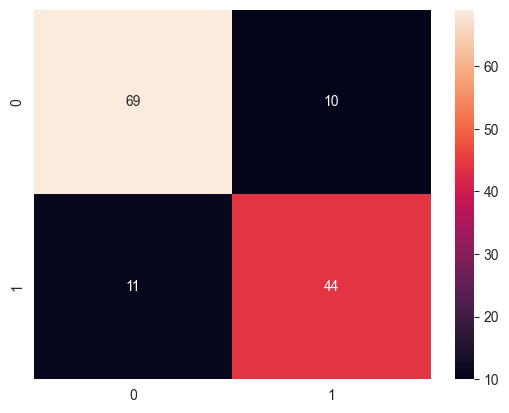

In [50]:
# plotting the confusion matrix in heatmap
matrix = metrics.confusion_matrix(Y_test_flat, Y_pred_rand)
sns.heatmap(matrix, annot=True, fmt='g')
show_and_save_current_matplotlib_plt("model_confusion_matrix.png")

# Co-Activation Graph

5/5 [==============================] - 0s 1ms/step


invalid value encountered in divide
invalid value encountered in divide


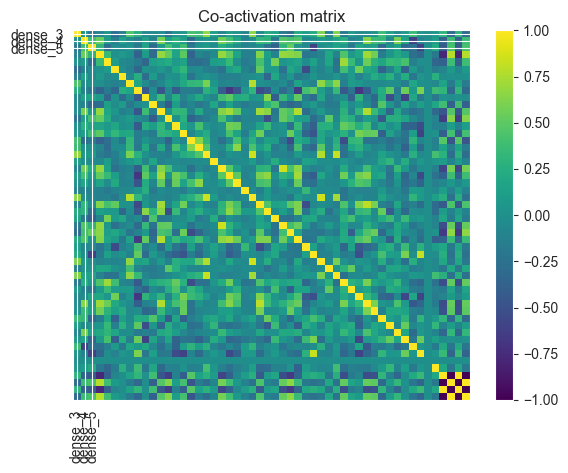

In [51]:
x = X_test

# Compute intermediate layer activations
layer_names = [layer.name for layer in model.layers]
outputs = [model.get_layer(name).output for name in layer_names]
model_reduced = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)
activations = model_reduced.predict(x)

# Compute model predictions on test data
predictions = [x for x in model.predict(x)]

# Concatenate predictions to activations
# Compute pairwise correlations between activations
activations_flat = np.concatenate([a.reshape(a.shape[0], -1) for a in activations], axis=1)
activations_flat = np.array([np.append(a, p) for a, p in zip(activations_flat, predictions)])
correlations = np.corrcoef(activations_flat, rowvar=False)

# Replace NaN values with 0 and remove corresponding rows and columns
correlations = np.nan_to_num(correlations)
nan_idx = np.where(np.isnan(correlations))[0]
if len(nan_idx) > 0:
    correlations = np.delete(correlations, nan_idx, axis=0)
    correlations = np.delete(correlations, nan_idx, axis=1)
    layer_names = [name for i, name in enumerate(layer_names) if i not in nan_idx]

# Plot co-activation matrix
plt.imshow(correlations, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Co-activation matrix')
plt.xticks(np.arange(len(layer_names)), layer_names, rotation=90)
plt.yticks(np.arange(len(layer_names)), layer_names)
show_and_save_current_matplotlib_plt("co_activation_matrix.png")


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


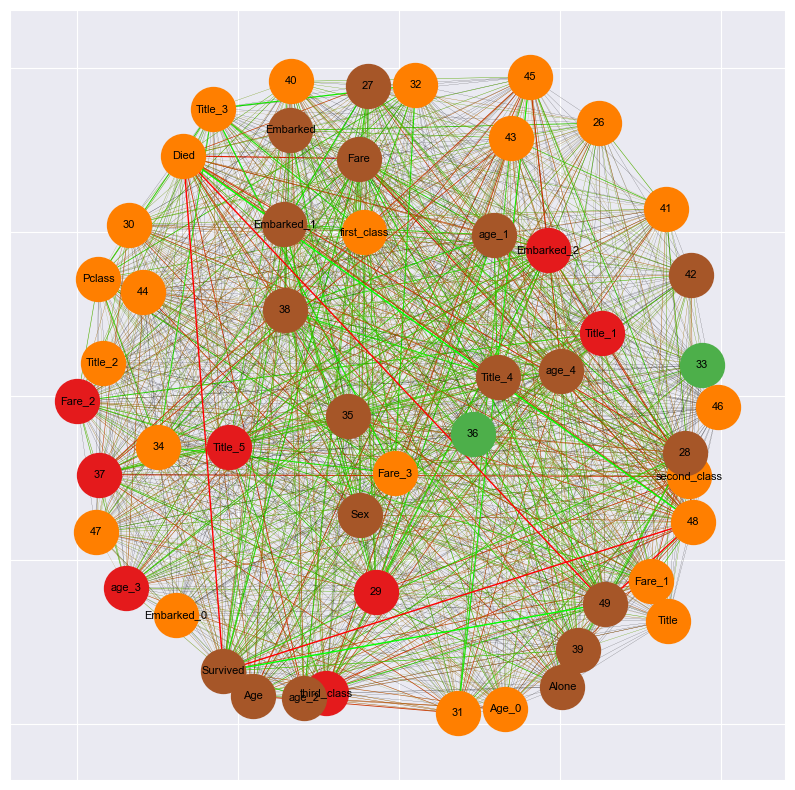

In [53]:
import networkx as nx
import matplotlib.colors as mcolors
from networkx.algorithms.community import louvain_communities

# defines the correlation threshold for the edges (0=everything will be shown, range=(-1,1))
threshold = 0

num_nodes = correlations.shape[0]
survived_output = num_nodes-1
died_output = num_nodes-2

# Define the node names as a list
# Create a dictionary that maps node indices to node names
node_labels = {i: (X_train.columns[i] if i < len(X_train.columns) else i) for i in range(num_nodes-2)}
node_labels.update({survived_output: "Survived"})
node_labels.update({died_output: "Died"})

min_v = 0.1
# Create the graph
G = nx.Graph()
for i in range(correlations.shape[0]):
    for j in range(i + 1, correlations.shape[1]):
        corr = min_v if (abs(correlations[i, j])) < min_v else correlations[i, j]
        if abs(corr) >= threshold:
            G.add_edge(i, j, weight=corr)

# resolution 1.2 to slightly bias more cluster division, threshold 0.5 as research supports this
clusters = louvain_communities(G, weight='weight', resolution=1.2, threshold=0.5, seed=123)

# Draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G, weight='weight', k=1.8)
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=50)
nx.draw_networkx_labels(G, pos, font_size=8, labels=node_labels)

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edges = list(edges)
weights = list(weights)

# this part will do the edge colorization
min_w, max_w = -1, 1
red = mcolors.hex2color('#FF0000')  # red color in RGB format
green = mcolors.hex2color('#00FF00')  # green color in RGB format
edge_colors = []
for w in weights:
    if abs(w) <= min_v:
        edge_colors.append('black')
    else:
        # Map the weight value to a value between 0 and 1
        normalized_w = (w - min_w) / (max_w - min_w)

        # Use a linear interpolation to determine the color between red and green
        color = tuple((1 - normalized_w) * c1 + normalized_w * c2 for c1, c2 in zip(red, green))

        # Convert the color to hexadecimal format and append it to the list
        edge_colors.append(mcolors.rgb2hex(color))

# draw the network edges
edges, weights = zip(*[(edges[i], round(weights[i], 1)) for i in range(len(edges)) if abs(weights[i]) >= threshold])
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=weights, edge_cmap=plt.cm.coolwarm)

# draw the louvain communities
colors = {}
for i, community in enumerate(clusters):
    color = plt.cm.Set1(i / len(clusters))
    colors.update({node: color for node in community})

for c in clusters:
    nx.draw_networkx_nodes(G, pos, nodelist=list(c), node_color=colors[list(c)[0]], node_size=1000)
show_and_save_current_matplotlib_plt("co_activation_graph.png")

## SHAP (SHapley Additive exPlanations)

In [54]:
import shap
import logging
import pickle
import os

recalc = False
logging.getLogger('shap').setLevel(logging.WARNING)

shap_values_full_model_fname = f"{MODEL_DIR}/shap_values_full_model.txt"
shap_values_full_per_cluster_fname = f"{MODEL_DIR}/shap_values_per_cluster.txt"
shap_values_full_per_feature_fname = f"{MODEL_DIR}/shap_values_per_feature.txt"

In [55]:
def sample_size_full_model():
    return 500


def relative_node_sample_size(cluster_size):
    return sample_size_full_model() / cluster_size

### Full SHAP

In [56]:
def do_or_load_and_write(func, file):
    if not recalc and os.path.exists(file):
        print(f'loading from file {file}')
        with open(file, 'rb') as f:
            return pickle.load(f)
    else:
        print(f'not loading from file {file}, running func and returning...')
        r = func()
        with open(file, 'wb') as f:
            pickle.dump(r, f)
        return r

In [57]:
%%capture test

# This is the full SHAP explainer (begin layer to end layer)
def _2_class_to_binary_f(X, model):
    return np.array([0 if x[0] > x[1] else 1 for x in model.predict(X)])


def calc_full_shap():
    full_explainer = shap.Explainer(lambda x: _2_class_to_binary_f(x, model), X_test)
    sample_size = sample_size_full_model()
    print(f"Using full-model sample size {sample_size_full_model()}")
    return full_explainer(shap.utils.sample(X_test, sample_size))

In [58]:
%%capture test
full_shap_values = do_or_load_and_write(calc_full_shap, shap_values_full_model_fname)

In [59]:
def get_aggregated_model_shap(clazz, agg_func=lambda x: np.mean(np.abs(x))) -> dict:
    assert clazz in {0, 1}
    return {f: agg_func((full_shap_values.values[:, idx])) * (1 if clazz == 1 else -1) for idx, f in
            enumerate(X_train.columns)}


survived_mean_shap_vals = get_aggregated_model_shap(clazz=1)
died_mean_shap_vals = get_aggregated_model_shap(clazz=0)
full_model_shap_values = get_aggregated_model_shap(1, lambda x: x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


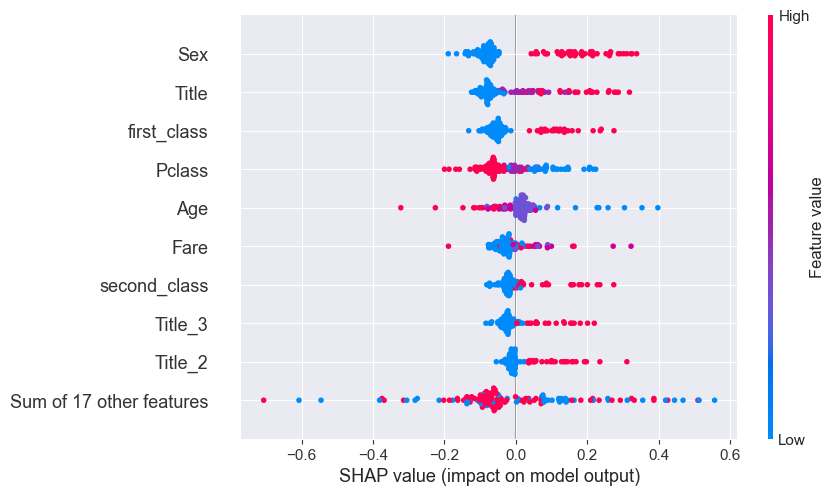

In [60]:
shap.plots.beeswarm(full_shap_values)

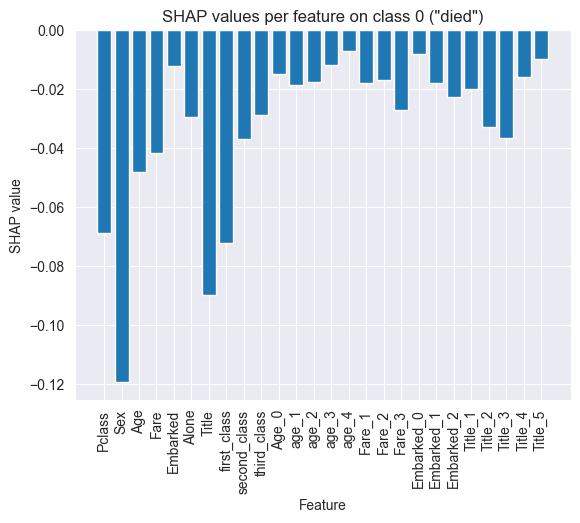

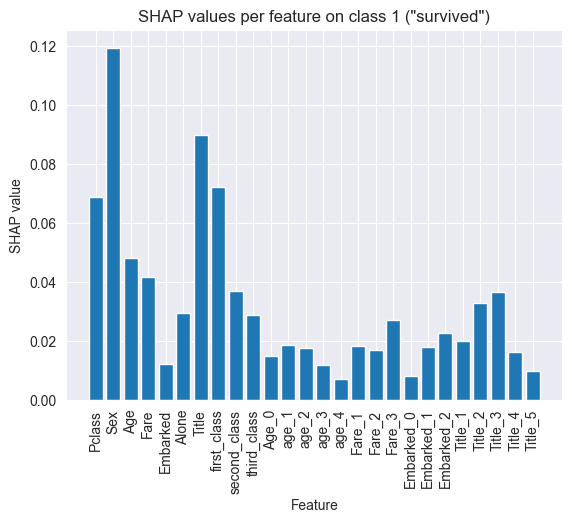

In [61]:
plt.bar(died_mean_shap_vals.keys(), died_mean_shap_vals.values())
plt.xlabel('Feature')
plt.ylabel('SHAP value')
plt.xticks(rotation=90)
plt.title('SHAP values per feature on class 0 ("died")')
show_and_save_current_matplotlib_plt("model_shap_values_bar_chart_died.png")

plt.bar(survived_mean_shap_vals.keys(), survived_mean_shap_vals.values())
plt.xlabel('Feature')
plt.ylabel('SHAP value')
plt.xticks(rotation=90)
plt.title('SHAP values per feature on class 1 ("survived")')
show_and_save_current_matplotlib_plt("model_shap_values_bar_chart_survived.png")

### Clustered SHAP

In [62]:
named_clusters = {f"cluster_{i}": c for i, c in enumerate(clusters)}
named_clusters

{'cluster_0': {9, 13, 16, 20, 21, 25, 29, 37},
 'cluster_1': {33, 36},
 'cluster_2': {0,
  6,
  7,
  8,
  10,
  15,
  17,
  18,
  22,
  23,
  26,
  30,
  31,
  32,
  34,
  40,
  41,
  43,
  44,
  45,
  46,
  47,
  48,
  50},
 'cluster_3': {1,
  2,
  3,
  4,
  5,
  11,
  12,
  14,
  19,
  24,
  27,
  28,
  35,
  38,
  39,
  42,
  49,
  51}}

#### Steps new SHAP-research idea
1. Per node, per instance, activation SHAP values (per instance)
2. Per cluster, per feature, SHAP distribution
3. General SHAP values per feature on entire model
4. Check where general SHAP values per feature lay within the distribution per feature per cluster

In [63]:
nodes = set()
for c in clusters:
    for node in c:
        nodes.add(node)
print(f"Number of nodes: {len(nodes)}")

Number of nodes: 52


In [64]:
model_function_per_node = {}
node_num = 0
for layer_id, layer in enumerate(model.layers):
    m = tf.keras.Model(inputs=model.input, outputs=layer.output)
    for i in range(layer.output.shape[1]):
        if node_num in nodes:
            model_function_per_node[node_num] = m
        node_num += 1

In [65]:
def node_activation_f(X, node: int):
    if node in model_function_per_node:
        m = model_function_per_node[node]
        local_node_num = node % m.output.shape[1]
        return np.array([x[local_node_num] for x in m.predict(X)])
    raise Exception(f"{n} not in {model_function_per_node.keys()}")

In [66]:
%%capture test
nodes = [n for n in model_function_per_node.keys()]

clusters_size_per_node = {}
for c in clusters:
    for n in c:
        clusters_size_per_node[n] = len(c)

In [67]:
def calc_shap_per_feature():
    shap_values_per_feature = {x: {n: [] for n in nodes} for x in X_train.columns}

    current_node_number = nodes[0]
    ex = shap.Explainer(lambda x: node_activation_f(x, current_node_number), X_train)
    for n in nodes:
        sample_size = int(np.ceil(relative_node_sample_size(clusters_size_per_node[n])))
        sample = shap.utils.sample(X_test, sample_size)
        current_node_number = n
        vals = ex(sample).values
        for svarr in vals:
            for idx, sv in enumerate(svarr, 0):
                shap_values_per_feature[X_train.columns[idx]][n].append(sv)
    return shap_values_per_feature

In [68]:
%%capture test
shap_values_per_feature = do_or_load_and_write(calc_shap_per_feature, shap_values_full_per_feature_fname)

In [69]:
def calc_shap_per_cluster():
    shap_values_per_cluster = {c: {f: [] for f in X_train.columns} for c in named_clusters.keys()}
    for feature, n_sv in shap_values_per_feature.items():
        for node, sv in n_sv.items():
            for c_name, nodes in named_clusters.items():
                if node in nodes:
                    for _sv in sv:
                        shap_values_per_cluster[c_name][feature].append(_sv)
    return shap_values_per_cluster

In [70]:
shap_values_per_cluster = do_or_load_and_write(calc_shap_per_cluster, shap_values_full_per_cluster_fname)

not loading from file ../../output/titanic/models/experiment/MacBook-Pro-van-Bo_local/shap_values_per_cluster.txt, running func and returning...


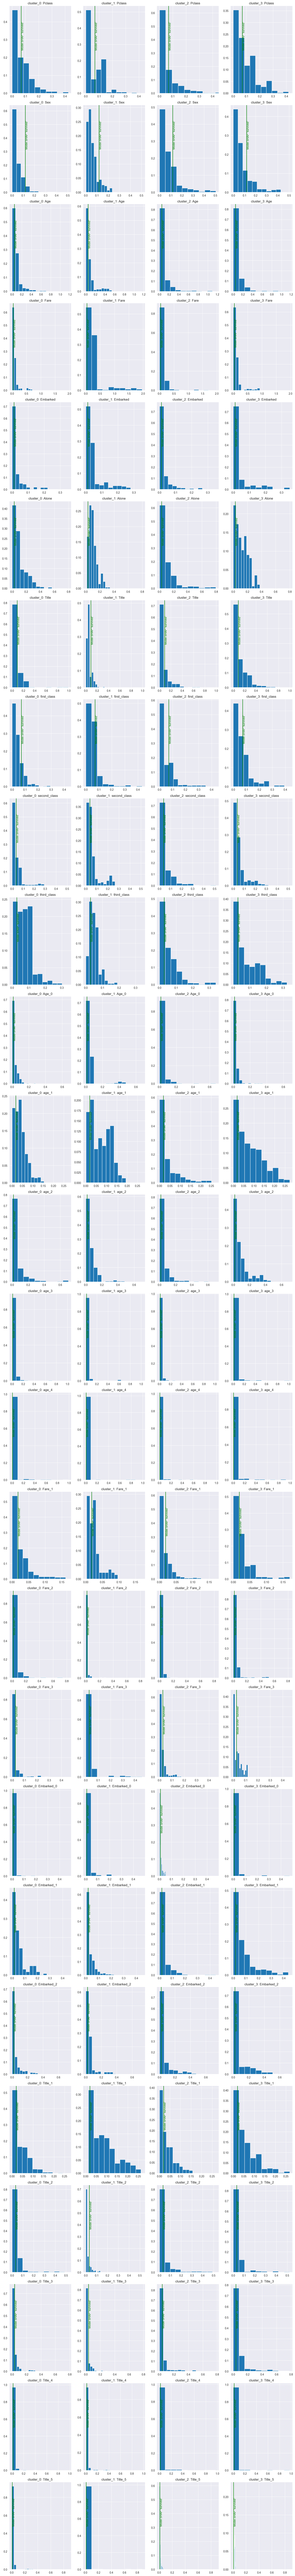

In [71]:
n = len(clusters) * len(X_train.columns)
cols = len(X_train.columns)
fig, axs = plt.subplots(nrows=min(n, cols),
                        ncols=int(np.ceil(n / cols)),
                        figsize=(15, 5 * min(n, cols)))
num = 0
x_lims = []
normalize_x_axis = True
for cluster, feature_svs in shap_values_per_cluster.items():
    for feature, sv in feature_svs.items():
        ax = axs[num % cols, num // cols]  # swap rows and cols
        data = np.abs(sv)
        ax.hist(np.abs(sv),
                weights=np.zeros_like(data) + 1. / data.size)  # add histogram to the current axis, make absolute
        model_shap_died = died_mean_shap_vals[feature]
        model_shap_survived = survived_mean_shap_vals[feature]
        ylim = ax.get_ylim()  # Get the y-axis limits
        ypos = (ylim[1] - ylim[0]) / 2 + ylim[0]
        ax.axvline(model_shap_survived, color='green')
        ax.text(model_shap_survived, ypos, 'Model SHAP "survived"', rotation=90, color='green')
        ax.set_title(f'{cluster}: {feature}')  # add title to the axis

        # Add the x limits of the current axis to the list of x limits for the current column
        if num % cols == 0:
            x_lims.append(ax.get_xlim())
        else:
            if num % cols < len(x_lims):
                x_lims[num % cols] = ax.get_xlim() if ax.get_xlim()[0] < x_lims[num % cols][0] else x_lims[num % cols]
            else:
                x_lims.append(ax.get_xlim())

        num += 1

if normalize_x_axis:
    # Set the same x limits for all the axes in each column
    for i in range(n_inputs):
        for j in range(len(clusters)):
            axs[i, j].set_xlim(x_lims[i])  # swap rows and cols

# adjust layout and show plot
fig.tight_layout()
show_and_save_current_matplotlib_plt("cluster_histograms.png")

In [72]:
import plotly.graph_objects as go

#real deal
n_bins = 50
y_range = [0,0.15]
x_range = [-2,2]
normalise = 'probability'

for cluster_name, feats_with_shaps  in shap_values_per_cluster.items():

    for feat_name, shap_values in feats_with_shaps.items():

        #main object
        fig = go.Figure()

        #first data (cluster specific)
        fig.add_trace(go.Histogram(
            x=shap_values, #shaps of feature of cluster
            histnorm=normalise,
            name=f'{feat_name} of {cluster_name}',
            nbinsx=n_bins,
            # marker_color='blue',
        ))

        #data for second plot: shaps of feature of the whole model
        fig.add_trace(go.Histogram(
            x=full_model_shap_values[feat_name],
            histnorm=normalise,
            name=f'{feat_name} of the actual model',
            nbinsx=n_bins,
            # marker_color='#EB89B5',
        ))


        #to tweak appearances
        fig.update_layout(barmode='overlay',
            title_text=f'Distributions of {feat_name} in {cluster_name} against whole model', # title of plot
            xaxis_title_text='Shapley value', # xaxis label
            yaxis_title_text='percentage', # yaxis label

            yaxis=dict(
                range=y_range
            ),
            xaxis=dict(
                range=x_range
            ),
        )

        # Reduce opacity to see both histograms
        fig.update_traces(opacity=0.7)
        show_and_save_current_plotly_plt(f'histg_{(feat_name.lower())}_{cluster_name}.png', fig, show=False)